In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [2]:
# Load customized capital calls schedule from Excel file
call_schedule_df = pd.read_excel('data/PM_call_schedule.xlsx', sheet_name='Schedule')
call_schedule_df

,Asset_Class,Geo_Area,1,2,3,4,5,6,7,8,9,10,11,12
0,Private Equity,"US,APAC,ROW",0.20,0.30,0.30,0.20,0.00,0,0,0,0,0,0,0
1,Private Equity,EU,0.20,0.25,0.35,0.15,0.05,0,0,0,0,0,0,0
2,Venture Capital,"US,APAC,ROW",0.20,0.30,0.30,0.15,0.05,0,0,0,0,0,0,0
3,Venture Capital,EU,0.20,0.30,0.30,0.15,0.05,0,0,0,0,0,0,0
4,Co-Investments,"EU,US,APAC,ROW",0.50,0.50,0.00,0.00,0.00,0,0,0,0,0,0,0
5,Private Debt,"EU,US,APAC,ROW",0.20,0.40,0.40,0.00,0.00,0,0,0,0,0,0,0
6,Real Estate,"EU,US,APAC,ROW",0.20,0.40,0.40,0.00,0.00,0,0,0,0,0,0,0
7,Real Assets,"EU,US,APAC,ROW",0.20,0.40,0.40,0.00,0.00,0,0,0,0,0,0,0
8,Private Diversifiers,"EU,US,APAC,ROW",0.20,0.40,0.40,0.00,0.00,0,0,0,0,0,0,0
9,Infrastructure,"EU,US,APAC,ROW",0.20,0.40,0.40,0.00,0.00,0,0,0,0,0,0,0


In [3]:
# Load Excel files
file_paths = [
    'data/Returns_Report_APAC.xlsx',
    'data/Returns_Report_EU.xlsx',
    'data/Returns_Report_ROW.xlsx',
    'data/Returns_Report_US.xlsx'
]

# Read all sheets into a list of dataframes and assign Geo_Region
df_list = [
    pd.read_excel(file_path, sheet_name='Returns Report', header=4).assign(Geo_Region=geo_region)
    for file_path, geo_region in zip(file_paths, ['APAC', 'EU', 'ROW', 'US'])
]

# Convert relevant columns to numeric values
data = pd.concat(df_list, ignore_index=True)

# Remove rows where 'Asset_Class' is 'Sub-Total'
data = data[data['Asset Class Group'] != 'Sub-Total']
columns_to_convert = data.columns[5:33]
data[columns_to_convert] = data[columns_to_convert].apply(pd.to_numeric, errors='coerce')

# Rename columns based on provided labels
column_mapping = {
    'Vintage Year': 'Vintage_Year',
    'Asset Class Group': 'Asset_Class',
    'First Transaction Period': 'First_Transaction_Period',
    'As of Date': 'As_of_Date',
    'Fund Count': 'Fund_Count',
    'Pooled Return (LP) (%)': 'IRR_Pooled',
    'Equal Weighted (LP) (%)': 'IRR_Equal_Weighted',
    'Capital Weighted (LP) (%)': 'IRR_Capital_Weighted',
    'Average (LP) (%)': 'IRR_Average',
    'Top 5% (LP) (%)': 'IRR_Top_5',
    'Upper Quartile (LP) (%)': 'IRR_Upper_Quartile',
    'Median (LP) (%)': 'IRR_Median',
    'Lower Quartile (LP) (%)': 'IRR_Lower_Quartile',
    'Bottom 5% (LP) (%)': 'IRR_Bottom_5',
    'Standard Deviation (LP) (%)': 'IRR_Std_Dev',
    'Pooled Return (LP)': 'TVPI_Pooled',
    'Capital Weighted (LP)': 'TVPI_Capital_Weighted',
    'Average (LP)': 'TVPI_Average',
    'Top 5% (LP)': 'TVPI_Top_5',
    'Upper Quartile (LP)': 'TVPI_Upper_Quartile',
    'Median (LP)': 'TVPI_Median',
    'Lower Quartile (LP)': 'TVPI_Lower_Quartile',
    'Bottom 5% (LP)': 'TVPI_Bottom_5',
    'Standard Deviation (LP)': 'TVPI_Std_Dev',
    'Pooled Return (LP).1': 'DPI_Pooled',
    'Capital Weighted (LP).1': 'DPI_Capital_Weighted',
    'Average (LP).1': 'DPI_Average',
    'Top 5% (LP).1': 'DPI_Top_5',
    'Upper Quartile (LP).1': 'DPI_Upper_Quartile',
    'Median (LP).1': 'DPI_Median',
    'Lower Quartile (LP).1': 'DPI_Lower_Quartile',
    'Bottom 5% (LP).1': 'DPI_Bottom_5',
    'Standard Deviation (LP).1': 'DPI_Std_Dev'
}
data.rename(columns=column_mapping, inplace=True)

# Drop rows with missing values
data.dropna(inplace=True)
# data

In [4]:
# Encode categorical data
le_asset_class = LabelEncoder()
le_geo_region = LabelEncoder()
data['Asset_Class'] = le_asset_class.fit_transform(data['Asset_Class'])
data['Geo_Region'] = le_geo_region.fit_transform(data['Geo_Region'])

# Calculate vintage weight based on recency
data['Vintage_Weight'] = data['Vintage_Year'] / data['Vintage_Year'].max()

# Function to get appropriate IRR, TVPI, and DPI columns based on quantile input
def get_quantile_columns(percent_quantile):
    if percent_quantile >= 95:
        irr_column = 'IRR_Top_5'
        tvpi_column = 'TVPI_Top_5'
        dpi_column = 'DPI_Top_5'
    elif percent_quantile >= 75:
        irr_column = 'IRR_Upper_Quartile'
        tvpi_column = 'TVPI_Upper_Quartile'
        dpi_column = 'DPI_Upper_Quartile'
    elif percent_quantile >= 50:
        irr_column = 'IRR_Median'
        tvpi_column = 'TVPI_Median'
        dpi_column = 'DPI_Median'
    elif percent_quantile >= 25:
        irr_column = 'IRR_Lower_Quartile'
        tvpi_column = 'TVPI_Lower_Quartile'
        dpi_column = 'DPI_Lower_Quartile'
    else:
        irr_column = 'IRR_Bottom_5'
        tvpi_column = 'TVPI_Bottom_5'
        dpi_column = 'DPI_Bottom_5'
    return irr_column, tvpi_column, dpi_column

# Function to calculate bow factor from TVPI
def calculate_bow_from_tvpi(TVPI, duration, life):
    """Calculate the bow parameter based on TVPI and duration."""
    return (TVPI / np.sqrt(2)) * np.exp(np.pi * duration / life)

# Function to calculate duration based on vintage-weighted TVPI and DPI
def calculate_duration(tvpi_value, dpi_value, life_years):
    """Estimate duration based on TVPI, DPI, and fund life."""
    # Duration is influenced by how quickly distributions are returned (DPI) and the growth of NAV (TVPI)
    return (tvpi_value * dpi_value) / life_years

# Function to estimate G_mean based on vintage-weighted IRR, TVPI, and DPI
def estimate_g_mean(irr_value, tvpi_value, dpi_value):
    """Estimate the average growth rate (G_mean) based on IRR, TVPI, and DPI."""
    # G_mean is influenced by the IRR and is adjusted based on the TVPI and DPI values
    return irr_value * (tvpi_value / dpi_value)


In [5]:
def forecast_ta_model(percent_quantile, asset_class, geo_region, fund_size, life_years, initial_nav):
    """Forecast T.A. model using fund size as a scaling factor for capital calls and distributions."""
    # Get appropriate columns based on quantile input
    irr_column, tvpi_column, dpi_column = get_quantile_columns(percent_quantile)
    
    # Filter data for the specific Geo_Region and Asset_Class
    asset_class_encoded = le_asset_class.transform([asset_class])[0]
    asset_class_decoded = le_asset_class.inverse_transform([asset_class_encoded])[0]
    geo_region_encoded = le_geo_region.transform([geo_region])[0]
    geo_region_decoded = le_geo_region.inverse_transform([geo_region_encoded])[0]
    filtered_data = data[(data['Geo_Region'] == geo_region_encoded) & (data['Asset_Class'] == asset_class_encoded)]
    
    # Get IRR, TVPI, and DPI values based on the filtered data and quantile columns with recent vintages weighted more heavily
    irr_value = (filtered_data[irr_column] * filtered_data['Fund_Count'] * filtered_data['Vintage_Weight']).sum() / (filtered_data['Fund_Count'] * filtered_data['Vintage_Weight']).sum()
    tvpi_value = (filtered_data[tvpi_column] * filtered_data['Fund_Count'] * filtered_data['Vintage_Weight']).sum() / (filtered_data['Fund_Count'] * filtered_data['Vintage_Weight']).sum()
    dpi_value = (filtered_data[dpi_column] * filtered_data['Fund_Count'] * filtered_data['Vintage_Weight']).sum() / (filtered_data['Fund_Count'] * filtered_data['Vintage_Weight']).sum()
    
    # Calculate duration based on TVPI and DPI
    duration = calculate_duration(tvpi_value, dpi_value, life_years)
    
    # Calculate bow factor from TVPI
    B = calculate_bow_from_tvpi(tvpi_value, duration, life_years)
    
    # Estimate G_mean based on IRR, TVPI, and DPI
    G_mean = estimate_g_mean(irr_value, tvpi_value, dpi_value)
    
    # Select the appropriate row based on asset class and geo region
    asset_class_condition = call_schedule_df['Asset_Class'] == asset_class
    geo_region_condition = call_schedule_df['Geo_Area'].str.contains(geo_region)
    if asset_class_condition.any() and geo_region_condition.any():
        call_schedule_row = call_schedule_df[asset_class_condition & geo_region_condition]
    else:
        call_schedule_row = call_schedule_df[(call_schedule_df['Asset_Class'] == 'Private Equity') & geo_region_condition]
    
    # Extract contribution rate from the selected row
    contribution_rate = call_schedule_row.iloc[:, 2:].values.flatten()
    yearly_calls = fund_size * np.array(contribution_rate)
    
    # Forecast NAV and distributions
    nav = [initial_nav]
    distributions = []
    for t in range(1, life_years + 1):
        # Contribution in period t
        C_t = yearly_calls[t - 1]
        
        # NAV at period t
        NAV_t = nav[-1] * (1 + G_mean) + C_t
        nav.append(NAV_t)
        
        # Distribution in period t, adjusted by DPI
        RD_t = max(0.05, (t / life_years) ** B)
        D_t = RD_t * NAV_t * dpi_value * (fund_size / 100)
        distributions.append(D_t)
        nav[-1] -= D_t
    
    # Plot forecasted cash flow streams
    plt.figure(figsize=(12, 8))
    years = range(1, life_years + 1)

    # Plot cumulative capital calls and distributions
    cumulative_calls = np.cumsum(yearly_calls)
    cumulative_distributions = np.cumsum(distributions)
    plt.figure(figsize=(9,6))
    plt.plot(years, cumulative_calls, label='Cumulative Capital Calls', color='tomato')
    plt.plot(years, cumulative_distributions, label='Cumulative Distributions', color='lime')

    # Plot histograms for individual capital calls and distributions
    plt.bar(years, -yearly_calls, width=0.4, alpha=0.6, label='Capital Calls', color='red', align='center')
    plt.bar(years, distributions, width=0.4, alpha=0.6, label='Distributions', color='green', align='edge')

    # Plot J-curve for net cash flow (difference of cashflows)
    net_cash_flow = np.array(distributions) - yearly_calls
    cumulative_net_cash_flow = np.cumsum(net_cash_flow)
    plt.plot(years, cumulative_net_cash_flow, label='J-Curve (Net Cash Flow)', color='blue', linestyle='--', linewidth=2)

    # Plot NAV over time
    # plt.plot(range(0, life_years + 1), nav, label='NAV', color='black', linestyle='-',  linewidth=2)

    # Add a horizontal black line at y=0
    plt.axhline(0, color='grey', linewidth=2)
    
    plt.xlabel('Year')
    plt.ylabel('Amount (Million $)')
    plt.title('Forecasted Cash Flow Streams: Capital Calls, Distributions and J-Curve')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Calculate performance statistics
    total_contributions = np.sum(yearly_calls)
    total_distributions = np.sum(distributions)
    multiple_on_invested_capital = total_distributions / total_contributions
    net_irrs = irr_value  # Assuming IRR as a direct performance indicator

    print("Performance Statistics:")
    print(f"Total Contributions: {total_contributions:.2f} Million $")
    print(f"Total Distributions: {total_distributions:.2f} Million $")
    print(f"Multiple on Invested Capital (MOIC): {multiple_on_invested_capital:.2f}")
    print(f"Net IRR: {net_irrs*100:.2f}%")
    
    return {
        'IRR_Value': irr_value,
        'Asset_Class': asset_class_decoded,
        'Geo_Region': geo_region_decoded,
        'TVPI_Value': tvpi_value,
        'DPI_Value': dpi_value,
        'Bow_Factor': B,
        'Duration': duration,
        'G_Mean': G_mean,
        'Yearly_Distribution': distributions[-1]
    }

Some Examples

<Figure size 1200x800 with 0 Axes>

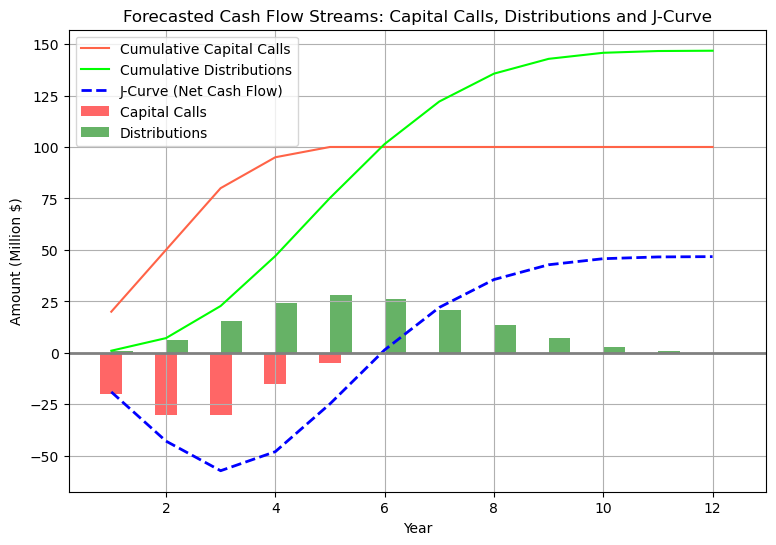

Performance Statistics:
Total Contributions: 100.00 Million $
Total Distributions: 146.75 Million $
Multiple on Invested Capital (MOIC): 1.47
Net IRR: 8.74%


In [6]:
forecast = forecast_ta_model(50, 'Venture Capital', 'US', 100, 12, 0)

<Figure size 1200x800 with 0 Axes>

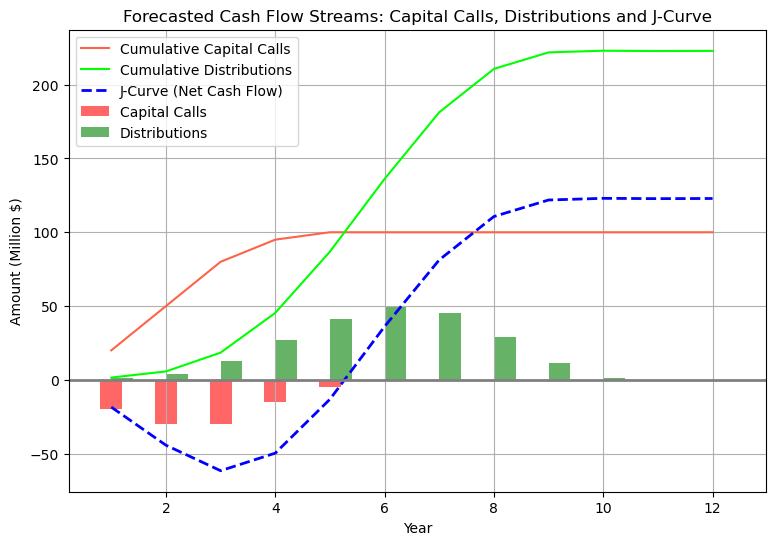

Performance Statistics:
Total Contributions: 100.00 Million $
Total Distributions: 222.88 Million $
Multiple on Invested Capital (MOIC): 2.23
Net IRR: 19.54%


In [7]:
forecast = forecast_ta_model(80, 'Venture Capital', 'US', 100, 12, 0)

<Figure size 1200x800 with 0 Axes>

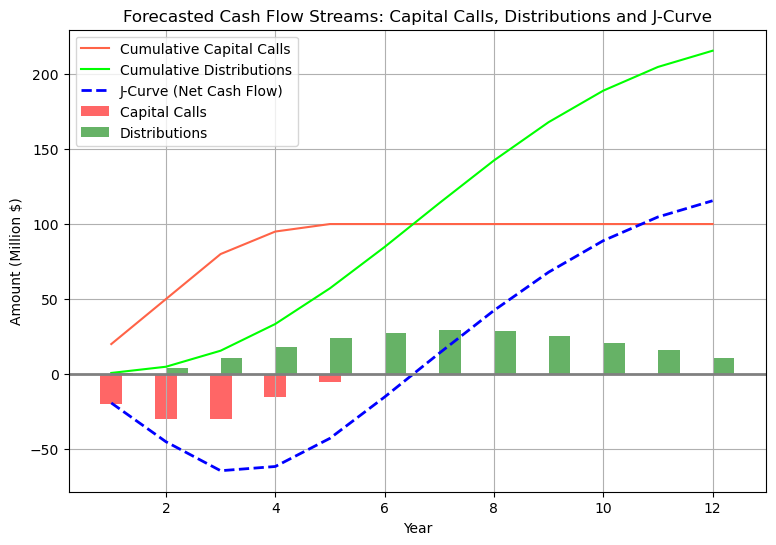

Performance Statistics:
Total Contributions: 100.00 Million $
Total Distributions: 215.53 Million $
Multiple on Invested Capital (MOIC): 2.16
Net IRR: 7.20%


In [8]:
forecast = forecast_ta_model(50, 'Venture Capital', 'EU', 100, 12, 0)

<Figure size 1200x800 with 0 Axes>

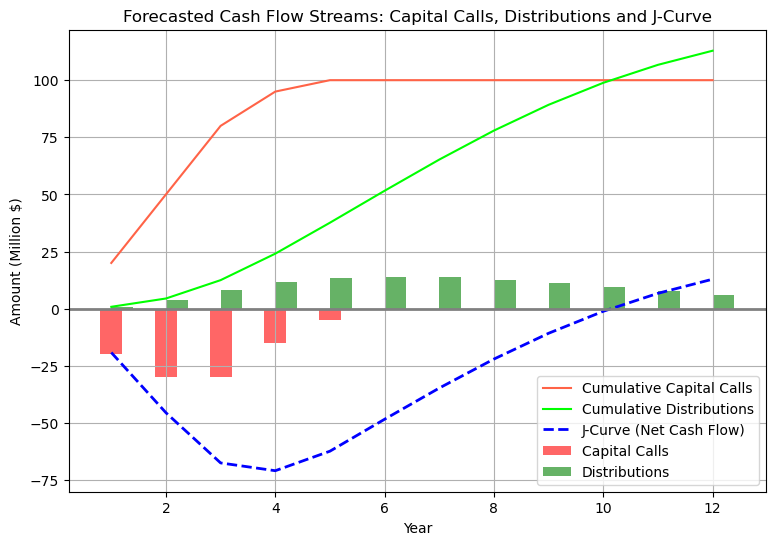

Performance Statistics:
Total Contributions: 100.00 Million $
Total Distributions: 112.89 Million $
Multiple on Invested Capital (MOIC): 1.13
Net IRR: 1.37%


In [9]:
forecast = forecast_ta_model(25, 'Venture Capital', 'EU', 100, 12, 0)

<Figure size 1200x800 with 0 Axes>

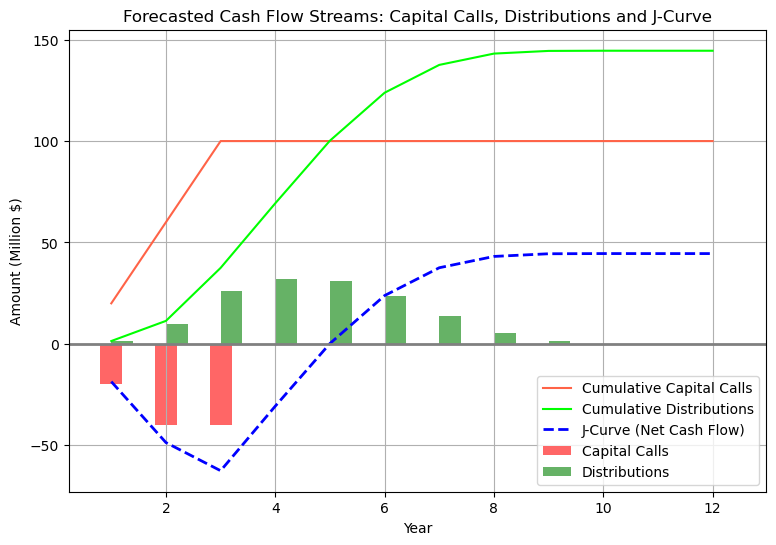

Performance Statistics:
Total Contributions: 100.00 Million $
Total Distributions: 144.53 Million $
Multiple on Invested Capital (MOIC): 1.45
Net IRR: 14.37%


In [10]:
forecast = forecast_ta_model(75, 'Real Estate', 'US', 100, 12, 0)

<Figure size 1200x800 with 0 Axes>

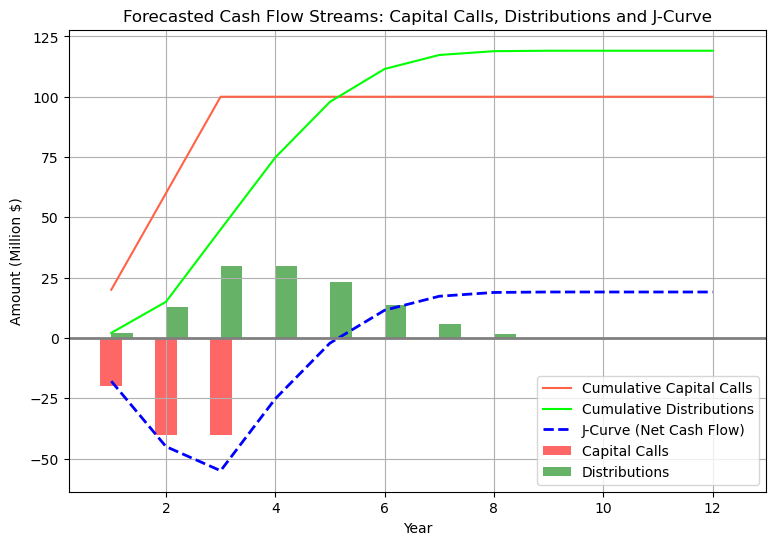

Performance Statistics:
Total Contributions: 100.00 Million $
Total Distributions: 119.07 Million $
Multiple on Invested Capital (MOIC): 1.19
Net IRR: 9.78%


In [11]:
forecast = forecast_ta_model(75, 'Real Estate', 'APAC', 100, 12, 0)

<Figure size 1200x800 with 0 Axes>

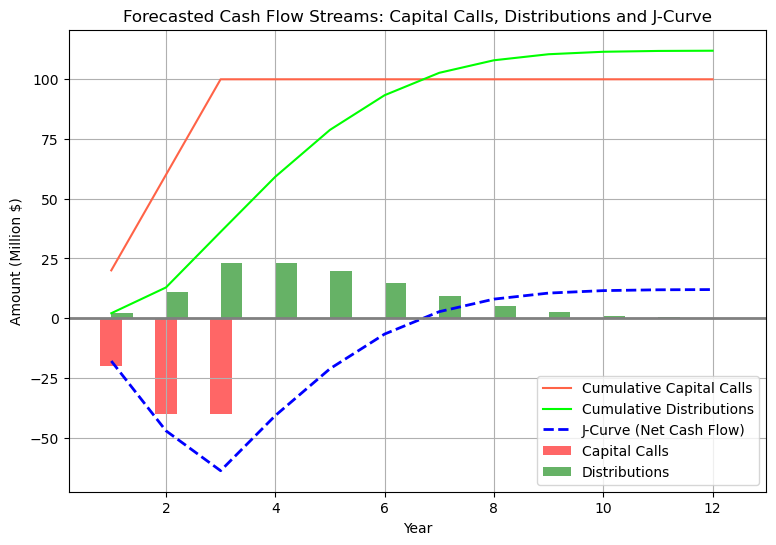

Performance Statistics:
Total Contributions: 100.00 Million $
Total Distributions: 111.96 Million $
Multiple on Invested Capital (MOIC): 1.12
Net IRR: 3.51%


In [12]:
forecast = forecast_ta_model(25, 'Real Estate', 'US', 100, 12, 0)

<Figure size 1200x800 with 0 Axes>

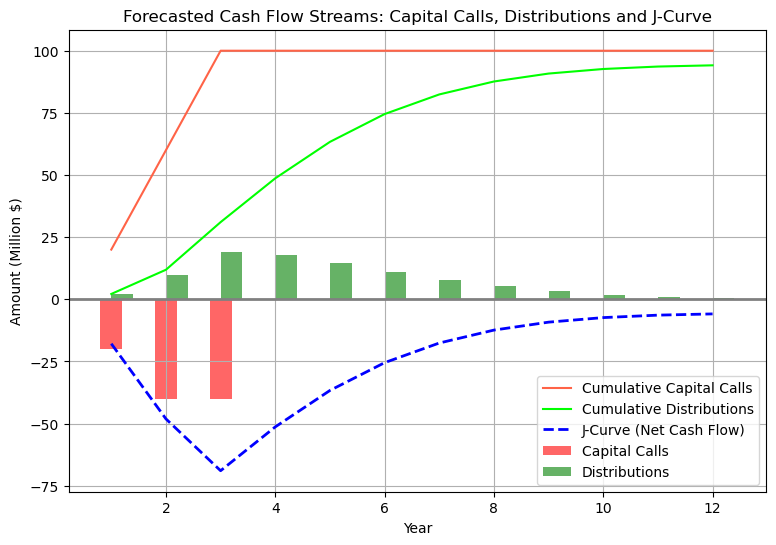

Performance Statistics:
Total Contributions: 100.00 Million $
Total Distributions: 94.13 Million $
Multiple on Invested Capital (MOIC): 0.94
Net IRR: -1.24%


In [13]:
forecast = forecast_ta_model(25, 'Real Estate', 'EU', 100, 12, 0)

<Figure size 1200x800 with 0 Axes>

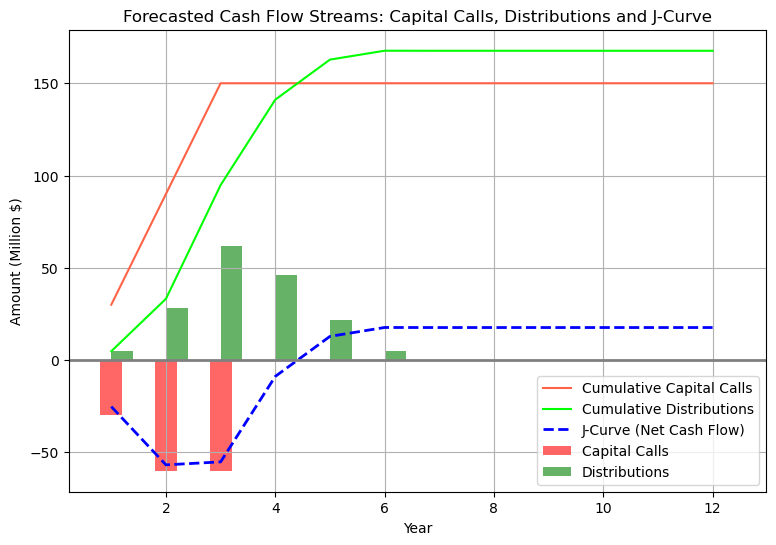

Performance Statistics:
Total Contributions: 150.00 Million $
Total Distributions: 167.61 Million $
Multiple on Invested Capital (MOIC): 1.12
Net IRR: 9.78%


In [18]:
forecast = forecast_ta_model(80, 'Real Estate', 'APAC', 150, 12, 0)

<Figure size 1200x800 with 0 Axes>

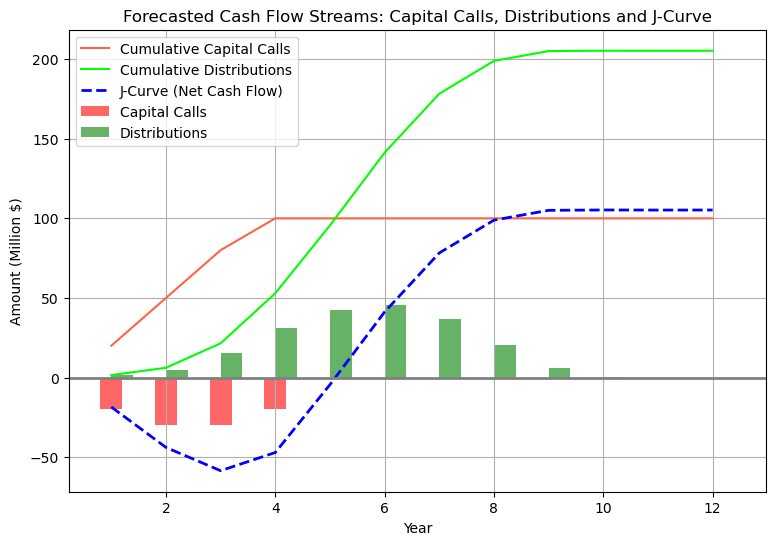

Performance Statistics:
Total Contributions: 100.00 Million $
Total Distributions: 205.23 Million $
Multiple on Invested Capital (MOIC): 2.05
Net IRR: 20.63%


In [14]:
forecast = forecast_ta_model(90, 'Buyout & Growth Equity', 'US', 100, 12, 0)

<Figure size 1200x800 with 0 Axes>

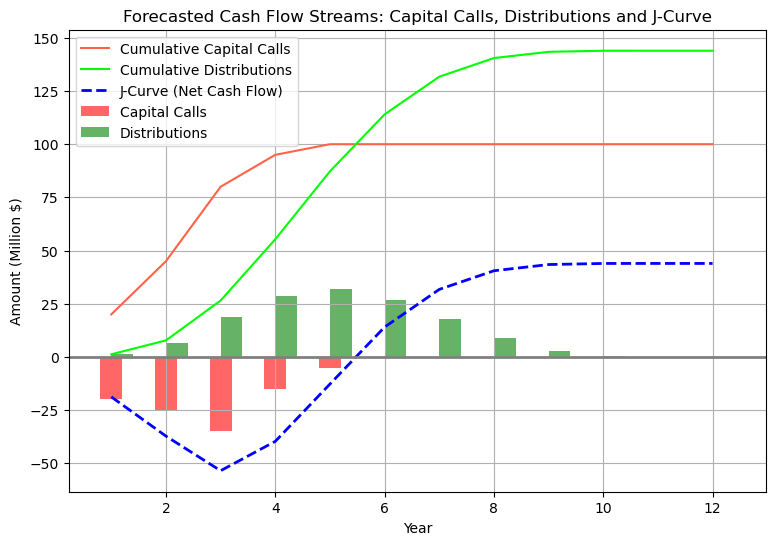

Performance Statistics:
Total Contributions: 100.00 Million $
Total Distributions: 143.94 Million $
Multiple on Invested Capital (MOIC): 1.44
Net IRR: 12.50%


In [15]:
forecast = forecast_ta_model(60, 'Buyout & Growth Equity', 'EU', 100, 12, 0)